In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data

import matplotlib.pyplot as plt

import sys 
sys.path.append('..')

from src.model.pmf import PMF

In [2]:
def RMSE(preds, truth):
    return np.sqrt(np.mean(np.square(preds-truth)))

In [3]:
batch_size = 1000
epoches = 1000
no_cuda = False
seed = 1
weight_decay = 0.1
embedding_feature_size = 100
ratio = 0.8
lr = 0.0001
momentum = 0.9

In [4]:
rp = pd.read_csv("../data/ml-1m/ratings.csv")
rp["rating"] = rp["rating"].astype("float")
rp = rp.sort_values(["user_id", "timestamp"])
rp.head()

,user_id,movie_id,rating,timestamp
31,0,3117,4.0,978300019
22,0,1250,5.0,978300055
27,0,1672,4.0,978300055
37,0,1009,5.0,978300055
24,0,2271,3.0,978300103


In [5]:
data = rp[["user_id", "movie_id", "rating"]].values
 
# Normalize rewards to [-1, 1]
data[:,2] = 0.5*(data[:,2] - 3)

# Shuffle data
np.random.shuffle(data)

In [6]:
# Split data
train_data = data[:int(ratio * data.shape[0])]
vali_data = data[int(ratio * data.shape[0]): int((ratio+(1-ratio)/2)*data.shape[0])]
test_data = data[int((ratio + (1 - ratio) / 2) * data.shape[0]) :]

In [7]:
NUM_USERS = 6040 # 943  
NUM_ITEMS = 3883 # 1682 

In [8]:
# Get CUDA device if available
cuda = torch.cuda.is_available()
 
# Set device to CUDA or CPU, depending on availability and desire
device = torch.device("cuda" if cuda and no_cuda else "cpu")
 
# Generate and apply seeds
torch.manual_seed(seed=seed)
if cuda:
    torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed=seed)
 
# Specify number of workers for cuda
kwargs = {"num_workers":1, "pin_memory":True} if cuda else {}
 
# Construct Data Loaders
train_data_loader = torch.utils.data.DataLoader(torch.from_numpy(train_data), batch_size=batch_size, shuffle=False, **kwargs)
test_data_loader = torch.utils.data.DataLoader(torch.from_numpy(test_data), batch_size=batch_size, shuffle=False, **kwargs)

In [9]:
# Initialize model
model = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, no_cuda=no_cuda)
 
# Move model to CUDA if CUDA selected
if cuda:
    model.cuda()
    print("Model moved to CUDA")
 
# Set loss function
loss_function = nn.MSELoss(reduction="sum")

# Set optimizer (uncomment Adam for adam)
# optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

Model moved to CUDA


In [10]:
# Function for training one epoch
def train(epoch, train_data_loader):
    # Initialize
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()
 
    # Go through batches
    for batch_idx, ele in enumerate(train_data_loader):
        # Zero optimizer gradient
        optimizer.zero_grad()
 
        # Extract user_id_nums: row 0, item_id_nums: col 1 , ratings: val 2
        row = ele[:, 0]
        col = ele[:, 1]
        val = ele[:, 2]
 
        # Set to variables
        row = Variable(row.long())
        if isinstance(col, list):
            col = tuple(Variable(c.long()) for c in col)
        else:
            col = Variable(col.long())
        val = Variable(val.float())

        # Move data to CUDA
        if cuda:
            row = row.cuda()
            col = col.cuda()
            val = val.cuda()
 
        # Train
        preds = model.forward(row, col)
        loss = loss_function(preds, val)
        loss.backward()
        optimizer.step()
 
        # Update epoch loss
        epoch_loss += loss.data
 
    epoch_loss /= train_data_loader.dataset.shape[0]
    return epoch_loss

In [11]:
# Training Model

train_loss_list = []
last_vali_rmse = None
train_rmse_list = []
vali_rmse_list = []
print("parameters are: train ratio:{:f},batch_size:{:d}, epoches:{:d}, weight_decay:{:f}".format(ratio, batch_size, epoches, weight_decay))
print(model)

# Go through epochs
for epoch in range(1, epoches+1):
 
    # Train epoch
    train_epoch_loss = train(epoch, train_data_loader)
 
    # Get epoch loss
    train_loss_list.append(train_epoch_loss.cpu())
 
    # Move validation data to CUDA
    if cuda:
        vali_row = Variable(torch.from_numpy(vali_data[:, 0]).long()).cuda()
        vali_col = Variable(torch.from_numpy(vali_data[:, 1]).long()).cuda()
    else:
        vali_row = Variable(torch.from_numpy(vali_data[:, 0]).long())
        vali_col = Variable(torch.from_numpy(vali_data[:, 1]).long())
 
    # Get validation predictions
    vali_preds = model.predict(vali_row, vali_col)
 
    # Calculate train rmse loss
    train_rmse = np.sqrt(train_epoch_loss.cpu())
 
    # Calculate validation rmse loss
    if cuda:
        vali_rmse = RMSE(vali_preds.cpu().data.numpy(), vali_data[:, 2])
    else:
        vali_rmse = RMSE(vali_preds.data.numpy(), vali_data[:, 2])
 
    # Add losses to rmse loss lists
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)
 
    print("Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}". \
              format(epoch, train_rmse, vali_rmse))
 
    # Early stop condition
    if last_vali_rmse and last_vali_rmse < vali_rmse:
        break
    else:
      last_vali_rmse = vali_rmse
 

parameters are: train ratio:0.800000,batch_size:1000, epoches:1000, weight_decay:0.100000
PMF(
  (user_embeddings): Embedding(6040, 100)
  (item_embeddings): Embedding(3883, 100)
  (ub): Embedding(6040, 1)
  (ib): Embedding(3883, 1)
)
Training epoch: 1, training rmse: 0.531544, vali rmse:0.513436
Training epoch: 2, training rmse: 0.501935, vali rmse:0.498676
Training epoch: 3, training rmse: 0.492218, vali rmse:0.493078
Training epoch: 4, training rmse: 0.487712, vali rmse:0.489687
Training epoch: 5, training rmse: 0.484605, vali rmse:0.486993
Training epoch: 6, training rmse: 0.482040, vali rmse:0.484653
Training epoch: 7, training rmse: 0.479782, vali rmse:0.482551
Training epoch: 8, training rmse: 0.477735, vali rmse:0.480625
Training epoch: 9, training rmse: 0.475845, vali rmse:0.478839
Training epoch: 10, training rmse: 0.474082, vali rmse:0.477170
Training epoch: 11, training rmse: 0.472426, vali rmse:0.475601
Training epoch: 12, training rmse: 0.470867, vali rmse:0.474124
Traini

Test rmse: 0.454731


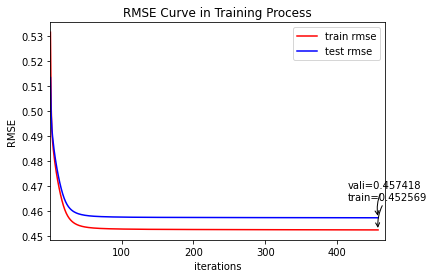

In [12]:
# Testing Model

# Move test set to CUDA
if cuda:
    test_row = Variable(torch.from_numpy(test_data[:, 0]).long()).cuda()
    test_col = Variable(torch.from_numpy(test_data[:, 1]).long()).cuda()
else:
    test_row = Variable(torch.from_numpy(test_data[:, 0]).long())
    test_col = Variable(torch.from_numpy(test_data[:, 1]).long())
 
# Get test predictions
preds = model.predict(test_row, test_col)
 
# Get test rmse loss
if cuda:
    test_rmse = RMSE(preds.cpu().data.numpy(), test_data[:, 2])
else:
    test_rmse = RMSE(preds.data.numpy(), test_data[:, 2])
print("Test rmse: {:f}".format(test_rmse))
 
# Create plots
plt.figure(1)
plt.figure(1).patch.set_facecolor("white")
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color="r", label="train rmse")
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color="b", label="test rmse")
plt.legend()
plt.annotate(r"train=%f" % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords="data", xytext=(-30, 30), textcoords="offset points", fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))
plt.annotate(r"vali=%f" % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords="data", xytext=(-30, 30), textcoords="offset points", fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel("iterations")
plt.ylabel("RMSE")
plt.title("RMSE Curve in Training Process")
plt.show()
 
# Save model
path_to_trained_pmf = "../model/pmf/ml_1m_emb_{:d}_ratio_{:f}_bs_{:d}_e_{:d}_wd_{:f}_lr_{:f}_trained_pmf.pt".format(embedding_feature_size, ratio, batch_size, len(train_rmse_list), weight_decay, lr)
torch.save(model.state_dict(), path_to_trained_pmf)

In [13]:
idx =  0 
model.predict(
    torch.tensor([data[idx][0]]).long().to("cuda"), 
    torch.tensor([data[idx][1]]).long().to("cuda")
).cpu().data[0] * 2 + 3

tensor(3.8824)

In [14]:
data[idx][2] * 2 + 3

2.0